In [1]:
import sys
from os.path import join, abspath, pardir
from glob import glob
import numpy as np
import pandas as pd
import vaex
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from time import time
from multiprocessing import Pool
import emcee
import corner
from scipy.stats import norm, uniform

In [2]:
# import utils
root_dir = abspath(pardir)
root_dir

'/home2/s20321005/Thesis-Project'

In [3]:
if root_dir not in sys.path:
    sys.path.append(root_dir)
sys.path

['/home2/s20321005/Thesis-Project/4_Gravity',
 '/home2/s20321005/.conda/envs/vaex/lib/python38.zip',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/lib-dynload',
 '',
 '/home2/s20321005/.local/lib/python3.8/site-packages',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/site-packages',
 '/home2/s20321005/Thesis-Project']

In [4]:
from utils import safe_mkdir, fw, nu_mod, style, progressbar

In [5]:
style()

In [8]:
root_data_dir = abspath(join(root_dir, "Data"))
root_data_dir

'/home2/s20321005/Thesis-Project/Data'

In [9]:
data_baryon_dir = join(root_data_dir, "Baryon")
data_velocity_dir = join(root_data_dir, "Velocity-Distribution-2")
data_eff_dir = join(root_data_dir, "Effective-Volume-2")

In [10]:
name = "MCMC-no"
data_dir = join(root_data_dir, name)
safe_mkdir(data_dir)

Directory /home2/s20321005/Thesis-Project/Data/MCMC-no already exist. Good to go!


In [11]:
# load baryons components
df_baryon = vaex.open(join(data_baryon_dir, "baryon.hdf5"))
df_baryon

#,components,rho,e_rho,sigma_z,e_sigma_z
0,Molecular gas (H2),0.0104,0.00312,3.7,0.2
1,Cold atomic gas (HI(1)),0.0277,0.00554,7.1,0.5
2,Warm atomic gas (HI(2)),0.0073,0.0007,22.1,2.4
3,Hot ionized gas (HII),0.0005,3e-05,39.0,4.0
4,Giant stars,0.0006,6e-05,15.5,1.6
...,...,...,...,...,...
7,4 < MV < 5,0.0029,0.00029,18.0,1.8
8,5 < MV < 8,0.0072,0.00072,18.5,1.9
9,MV > 8,0.0216,0.0028,18.5,4.0
10,White dwarfs,0.0056,0.001,20.0,5.0


In [12]:
rhos = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s

e_rhos = df_baryon["e_rho"].to_numpy()  # Msun/pc^3
e_sigmaz = df_baryon["e_sigma_z"].to_numpy() # km/s
dpi=100

In [13]:
# load data from files
number_files = glob(join(data_eff_dir, "*.hdf5"))
number_files.sort()
velocity_files = glob(join(data_velocity_dir, "gaia_*.hdf5"))
velocity_files.sort()
velocity_popt_files = glob(join(data_velocity_dir, "popt_gaia_*.hdf5"))
velocity_popt_files.sort()

# Functions

## probs

In [15]:
def log_prior(theta, locs, scales, norm_list, uni_list):
    pars_list = norm_list+uni_list
    result = 0
    for item in pars_list:
        if item in uni_list:
            result += np.sum(uniform.logpdf(theta[item], loc=locs[item], scale=scales[item]))
        elif item in norm_list:
            result += np.sum(norm.logpdf(theta[item], loc=locs[item], scale=scales[item]))
    return result

In [16]:
def log_likelihood_dm(theta, zdata, wdata):
    zmid, zdens, zerr = zdata
    wmid, wdens, werr = wdata
    Fz = nu_mod(zmid, **theta)
    Fw = fw(wmid, **theta)
    resz = np.sum(norm.logpdf(zdens, loc=Fz, scale=zerr))
    resw = np.sum(norm.logpdf(wdens, loc=Fw, scale=werr))
    return resz + resw

In [17]:
def log_posterior_no(theta, data, locs, scales, dim, norm_list, uni_list, simple=True):
    skip = 0 if simple else 24
    zdata, wdata = data
    theta_dict = dict(
        log_nu0=theta[skip+0],
        zsun=theta[skip+1],
        R=theta[skip+2],
        w0=theta[skip+3:skip+3+dim],
        log_sigma_w=theta[skip+3+dim:skip+3+2*dim],
        a=theta[skip+3+2*dim:skip+3+3*dim]
    )
    # theta_dict = dict(
    #     log_nu0=theta[skip+0],
    #     zsun=theta[skip+1],
    #     w0=theta[skip+2:skip+2+dim],
    #     log_sigma_w=theta[skip+2+dim:skip+2+2*dim],
    #     a=theta[skip+2+2*dim:skip+2+3*dim]
    # )
    if not simple:
        theta_dict['rhos'] = theta[:12]
        theta_dict['sigmaz'] = theta[12:24]
    else:
        theta_dict['rhos'] = rhos
        theta_dict['sigmaz'] = sigmaz
    log_prior_ = log_prior(theta_dict, locs, scales, norm_list, uni_list)
    if not np.isfinite(log_prior_):
        return -np.inf
    
    # theta_dict['R'] = R=3.4E-3
    theta_dict['rhoDM'] = 0
    theta_dict['sigmaDD'] = 0
    theta_dict['hDD'] = 1
    theta_dict['nu0'] = np.exp(theta_dict['log_nu0'])
    theta_dict['sigma_w'] = np.exp(theta_dict['log_sigma_w'])
    
    return log_prior_ + log_likelihood_dm(theta_dict, zdata, wdata)

## utils

In [18]:
from utils import load_data, plot_data, plot_corner, run_mcmc

In [19]:
def initialize_prior_no(dim, w0, sigma_w, a_raw, simple=True):
    uni_list = ['log_nu0', 'zsun', 'log_sigma_w', 'w0', 'a']
    # norm_list = []
    norm_list = ['R']
    
    locs = dict(
        log_nu0=np.log(1E-6), 
        zsun=-40, 
        R=3.4E-3, 
        w0=w0-20, 
        log_sigma_w=np.log(sigma_w*0.7), 
        a=a_raw*0.7
    )
    
    scales = dict(
        log_nu0=np.log(1E-4)-locs['log_nu0'], 
        zsun=40-locs['zsun'], 
        R=0.6E-3, 
        w0=np.repeat(40, dim), 
        log_sigma_w=np.log(sigma_w*1.3)-locs['log_sigma_w'], 
        a=np.abs(a_raw*0.6)
    )
    if not simple:
        norm_list += ['rhos', 'sigmaz']
        locs['rhos'] = rhos
        locs['sigmaz'] = sigmaz
        scales['rhos'] = e_rhos
        scales['sigmaz'] = e_sigmaz

    return locs, scales, uni_list, norm_list

In [20]:
def initialize_walkers_no(locs, scales, dim, simple=True):
    theta = np.concatenate([np.ravel(x) for x in locs.values()])
    ndim = len(theta)
    nwalkers = ndim*2+1

    log_nu0_0 = np.random.uniform(low=locs['log_nu0'], high=locs['log_nu0']+scales['log_nu0'], size=nwalkers)
    zsun_0 = np.random.uniform(low=locs['zsun'], high=locs['zsun']+scales['zsun'], size=nwalkers)
    R_0 = np.random.normal(loc=locs['R'], scale=scales['R'], size=nwalkers)
    w0_0 = np.random.uniform(low=locs['w0'], high=locs['w0']+scales['w0'], size=(nwalkers, dim))
    log_sigma_w_0 = np.random.uniform(low=locs['log_sigma_w'], high=locs['log_sigma_w']+scales['log_sigma_w'], size=(nwalkers, dim))
    a_0 = np.random.uniform(low=locs['a'], high=locs['a']+scales['a'], size=(nwalkers, dim))

    p0 = []

    if not simple:
        rhos_0 = np.random.normal(loc=locs['rhos'], scale=scales['rhos'], size=(nwalkers, 12))
        sigmaz_0 = np.random.normal(loc=locs['sigmaz'], scale=scales['sigmaz'], size=(nwalkers, 12))
        p0 = np.array([*rhos_0.T, *sigmaz_0.T, log_nu0_0, zsun_0, R_0, *w0_0.T, *log_sigma_w_0.T, *a_0.T]).T
        # p0 = np.array([*rhos_0.T, *sigmaz_0.T, log_nu0_0, zsun_0, *w0_0.T, *log_sigma_w_0.T, *a_0.T]).T
    else:
        p0 = np.array([log_nu0_0, zsun_0, R_0, *w0_0.T, *log_sigma_w_0.T, *a_0.T]).T
        # p0 = np.array([log_nu0_0, zsun_0, *w0_0.T, *log_sigma_w_0.T, *a_0.T]).T
    return p0, ndim, nwalkers

In [21]:
def sample_rhob(rhos, e_rhos, nsteps, nwalkers):
    rhob = np.zeros((nsteps, nwalkers, 12))
    for i in range(12):
        rhob[:, :, i] = np.random.normal(loc=rhos[i], scale=e_rhos[i], size=(nsteps, nwalkers))
    return rhob

In [32]:
# full
def consume_samples_no(samples_raw, dim, simple=True, flatten=False):
    skip = 0
    tot = 5
    labels = []
    if flatten:
        labels = [
            r"$\rho_{b}\times 10^2 [M_{\odot}$ pc$^{-3}]$",
            r"$\rho_{d}\times 10^2 [M_{\odot}$ pc$^{-3}]$",
            r"$\nu_0\times 10^5 [$pc$^{-3}]$", 
            r"$z_{\odot}$ [pc]", 
            r"$R\times 10^3 [M_{\odot}$ pc$^{-3}]$",
            r"$w_0$ [km/s]",
            r"$\sigma_{w}$ [km/s]"]
    else:
        labels = [
            r"$\rho_{b}\times 10^2 [M_{\odot}$ pc$^{-3}]$",
            r"$\rho_{d}\times 10^2 [M_{\odot}$ pc$^{-3}]$",
            r"$\log \nu_0\times [$pc$^{-3}]$", 
            r"$z_{\odot}$ [pc]", 
            r"$R\times 10^3 [M_{\odot}$ pc$^{-3}]$",
            r"$w_0$ [km/s]",
            r"$\log\ \sigma_{w}$ [km/s]"]
    rho_b = 0
    rho_d = 0
    sh = samples_raw.shape
    if simple:
        labels = labels[2:]
    else:
        tot += 2
        rho_b = sample_rhob(rhos, e_rhos, sh[0], sh[1])
        rho_d = samples_raw[:, :, 0:12] - rho_b
        rho_b = np.sum(rho_b, axis=2)
        rho_d = np.sum(rho_d, axis=2)
        skip = 24 
    samples = np.concatenate((samples_raw, np.zeros((sh[0], sh[1], 1))), axis=2).copy()
    samples = samples[:, :, skip:skip+tot]
    w0 = samples_raw[:, :, skip+3:skip+3+dim]
    log_sigma_w = samples_raw[:, :, skip+3+dim:skip+3+2*dim]
    a = samples_raw[:, :, skip+3+2*dim:skip+3+3*dim]

    samples[:, :, 2] = samples[:, :, 2]/1E-3 # R
    samples[:, :, 3] = np.average(w0, axis=2, weights=a) # w0
    if flatten:
        sigma_w = np.exp(log_sigma_w)
        samples[:, :, 0] = np.exp(samples[:, :, 0])/1E-5 # nu0
        samples[:, :, 4] = np.average(sigma_w, axis=2, weights=a) # sigma_w
    else:
        samples[:, :, 4] = np.average(log_sigma_w, axis=2, weights=a) # sigma_w
    if not simple:
        # shift
        for i in range(tot-1,1, -1):
            samples[:, :, i] = samples[:, :, i-2]
        samples[:, :, 1] = rho_d/1E-2
        samples[:, :, 0] = rho_b/1E-2
    if flatten:
        samples = samples.reshape(-1, tot)
    return samples, labels

In [182]:
# # no R
# def consume_samples_no(samples_raw, dim, simple=True, flatten=False):
#     skip = 0
#     tot = 4
#     labels = []
#     if flatten:
#         labels = [
#             r"$\rho_{b}\times 10^2 [M_{\odot}$ pc$^{-3}]$",
#             r"$\rho_{d}\times 10^2 [M_{\odot}$ pc$^{-3}]$",
#             r"$\nu_0\times 10^5 [$pc$^{-3}]$", 
#             r"$z_{\odot}$ [pc]", 
#             r"$w_0$ [km/s]",
#             r"$\sigma_{w}$ [km/s]"]
#     else:
#         labels = [
#             r"$\rho_{b}\times 10^2 [M_{\odot}$ pc$^{-3}]$",
#             r"$\rho_{d}\times 10^2 [M_{\odot}$ pc$^{-3}]$",
#             r"$\log \nu_0\times [$pc$^{-3}]$", 
#             r"$z_{\odot}$ [pc]", 
#             r"$w_0$ [km/s]",
#             r"$\log\ \sigma_{w}$ [km/s]"]
#     rho_b = 0
#     rho_d = 0
#     if simple:
#         labels = labels[2:]
#     else:
#         tot += 2
#         rho_b = sample_rhob(rhos, e_rhos, sh[0], sh[1])
#         rho_d = samples_raw[:, :, 0:12] - rho_b
#         skip = 24 
#     sh = samples_raw.shape
#     samples = np.concatenate((samples_raw, np.zeros((sh[0], sh[1], 1))), axis=2).copy()
#     samples = samples[:, :, skip:skip+tot]
#     w0 = samples_raw[:, :, skip+2:skip+2+dim]
#     log_sigma_w = samples_raw[:, :, skip+2+dim:skip+2+2*dim]
#     a = samples_raw[:, :, skip+2+2*dim:skip+2+3*dim]

#     samples[:, :, 2] = np.average(w0, axis=2, weights=a) # w0
#     if flatten:
#         sigma_w = np.exp(log_sigma_w)
#         samples[:, :, 0] = np.exp(samples[:, :, 0])/1E-5 # nu0
#         samples[:, :, 3] = np.average(sigma_w, axis=2, weights=a) # sigma_w
#     else:
#         samples[:, :, 3] = np.average(log_sigma_w, axis=2, weights=a) # sigma_w
#     if not simple:
#         # shift
#         for i in range(tot-1,1, -1):
#             samples[:, :, i] = samples[:, :, i-2]
#         samples[:, :, 1] = rho_d/1E-2
#         samples[:, :, 0] = rho_b/1E-2
#     if flatten:
#         samples = samples.reshape(-1, tot)
#     return samples, labels

In [23]:
# full
def plot_fitting_no(sampler, data, dim, alpha=0.01, n=200, log=False, path=None, simple=True, dpi=150):
    zdata, wdata = data
    zmid, zdens, zerr = zdata
    wmid, wdens, werr = wdata
    # plot two subplot
    flat_samples = sampler.get_chain(flat=True).copy()
    zs = np.linspace(zmid.min(), zmid.max(), 100)
    ws = np.linspace(wmid.min(), wmid.max(), 100)

    fig, axes = plt.subplots(2, 1, figsize=(10, 10))
    axes[0].errorbar(zmid, zdens, yerr=zerr, fmt='.', label='data')
    axes[0].set_xlabel(r'$z$')
    axes[0].set_ylabel(r'$\nu(z)$')
    axes[0].legend()
    axes[1].errorbar(wmid, wdens, yerr=werr, fmt='.', label='data')
    axes[1].set_xlabel(r'w')
    axes[1].set_ylabel(r'fw')
    axes[1].legend()
    skip = 0 if simple else 24
    if log:
        axes[0].set_yscale('log')
        axes[1].set_yscale('log')
    for i in tqdm(range(n)):
        index = np.random.randint(0, len(flat_samples))
        theta_dict = dict(
            rhoDM=0,
            sigmaDD=0,
            hDD=1,
            nu0=np.exp(flat_samples[index, skip+0]),
            zsun=flat_samples[index, skip+1],
            R=flat_samples[index, skip+2],
            w0=flat_samples[index, skip+3:skip+3+dim],
            sigma_w=np.exp(flat_samples[index, skip+3+dim:skip+3+2*dim]),
            a=flat_samples[index, skip+3+2*dim:skip+3+3*dim]
        )
        if not simple:
            theta_dict['rhos'] = flat_samples[index, :12]
            theta_dict['sigmaz'] = flat_samples[index, 12:24]
        else:
            theta_dict['rhos'] = rhos
            theta_dict['sigmaz'] = sigmaz
        nu = nu_mod(zs, **theta_dict)
        axes[0].plot(zs, nu, label='model', c="r", alpha=alpha)
        Fw = fw(ws, **theta_dict)
        axes[1].plot(ws, Fw, label='model', c="r", alpha=alpha)
    if path is not None:
        fig.savefig(path, dpi=dpi)
    fig.show()

In [184]:
# # no R
# def plot_fitting_no(sampler, data, dim, alpha=0.01, n=200, log=False, path=None, simple=True, dpi=150):
#     zdata, wdata = data
#     zmid, zdens, zerr = zdata
#     wmid, wdens, werr = wdata
#     # plot two subplot
#     flat_samples = sampler.get_chain(flat=True).copy()
#     zs = np.linspace(zmid.min(), zmid.max(), 100)
#     ws = np.linspace(wmid.min(), wmid.max(), 100)

#     fig, axes = plt.subplots(2, 1, figsize=(10, 10))
#     axes[0].errorbar(zmid, zdens, yerr=zerr, fmt='.', label='data')
#     axes[0].set_xlabel(r'$z$')
#     axes[0].set_ylabel(r'$\nu(z)$')
#     axes[0].legend()
#     axes[1].errorbar(wmid, wdens, yerr=werr, fmt='.', label='data')
#     axes[1].set_xlabel(r'w')
#     axes[1].set_ylabel(r'fw')
#     axes[1].legend()
#     skip = 0 if simple else 24
#     if log:
#         axes[0].set_yscale('log')
#         axes[1].set_yscale('log')
#     for i in tqdm(range(n)):
#         index = np.random.randint(0, len(flat_samples))
#         theta_dict = dict(
#             rhoDM=0,
#             sigmaDD=0,
#             hDD=1,
#             nu0=np.exp(flat_samples[index, skip+0]),
#             zsun=flat_samples[index, skip+1],
#             R=3.4E-3,
#             w0=flat_samples[index, skip+2:skip+2+dim],
#             sigma_w=np.exp(flat_samples[index, skip+2+dim:skip+2+2*dim]),
#             a=flat_samples[index, skip+2+2*dim:skip+2+3*dim]
#         )
#         if not simple:
#             theta_dict['rhos'] = flat_samples[index, :12]
#             theta_dict['sigmaz'] = flat_samples[index, 12:24]
#         else:
#             theta_dict['rhos'] = rhos
#             theta_dict['sigmaz'] = sigmaz
#         nu = nu_mod(zs, **theta_dict)
#         axes[0].plot(zs, nu, label='model', c="r", alpha=alpha)
#         Fw = fw(ws, **theta_dict)
#         axes[1].plot(ws, Fw, label='model', c="r", alpha=alpha)
#     if path is not None:
#         fig.savefig(path, dpi=dpi)
#     fig.show()

In [24]:
def get_dataframe_no(sampler_new, dim, locs, scales, norm_list, uni_list, nwalkers, simple=True):
    flat_samples = sampler_new.get_chain().copy()
    log_posterior_chain = sampler_new.get_log_prob().copy()
    thetas = []
    t0 = time()
    t1 = t0
    skip = 0 if simple else 24
    delta = 0
    for i, post in enumerate(log_posterior_chain.T):
        delta  = t1-t0
        progressbar(i/nwalkers*100, 30, flush=True, delta=delta, )
        for samples, lg_posterior in zip(tqdm(flat_samples[:, i], desc=f"{i}/{nwalkers}"), post):
            theta = {
                "log_nu0": samples[skip+0],
                "zsun": samples[skip+1],
                "R": samples[skip+2],
                "w0": samples[skip+3:skip+3+dim],
                "log_sigma_w": samples[skip+3+dim:skip+3+2*dim],
                "a": samples[skip+3+2*dim:skip+3+3*dim]
            }
            if simple:
                theta['rhos'] = rhos
                theta['sigmaz'] = sigmaz
            else:
                theta['rhos'] = samples[:12]
                theta['sigmaz'] = samples[12:24]
            lg_prior = log_prior(theta, locs, scales, norm_list, uni_list)
            theta['log_prior'] = lg_prior
            theta['log_posterior'] = lg_posterior
            theta['log_likelihood'] = lg_posterior - lg_prior
            del theta['w0'], theta['log_sigma_w'], theta['a'], theta['rhos'], theta['sigmaz']
            for j in range(dim):
                theta[f"w0_{j}"] = samples[skip+3+j]
                theta[f"log_sigma_w_{j}"] = samples[skip+3+dim+j]
                theta[f"a_{j}"] = samples[skip+3+2*dim+j]
            if not simple:
                for j in range(12):
                    theta[f"rhob_{j}"] = samples[j]
                    theta[f"sigmaz_{j}"] = samples[12+j]
            theta['walker'] = i
            thetas.append(theta)
        t1 = time()
    t1 = time()
    delta = t1-t0
    progressbar(100, 30, flush=True, delta=delta)
    print(f"Time: {t1-t0:.2f} s")
    df = pd.DataFrame(thetas)
    ## save
    df_dm = vaex.from_pandas(df)
    return df_dm

gaia_(0.04)_(0.10).hdf5


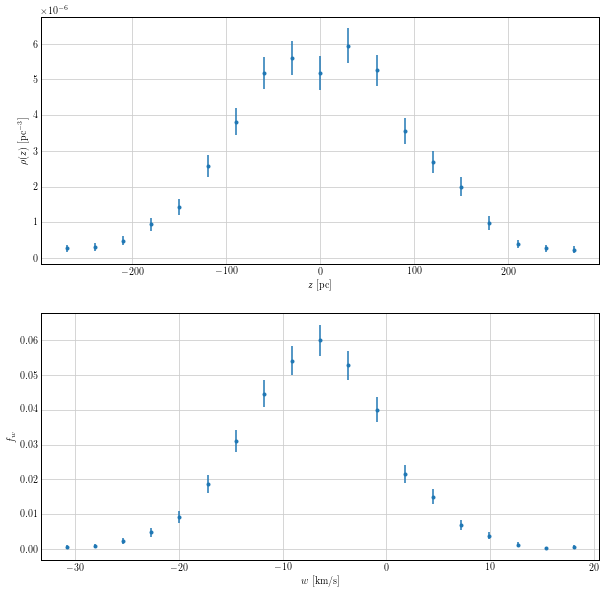

In [94]:
index = 1
simple = True
data, dim, w0, sigma_w, a_raw, name = load_data(index, number_files, velocity_files, velocity_popt_files)
print(name)
## plot data
plot_data(data)

In [95]:
## initialize prior
locs, scales, uni_list, norm_list = initialize_prior_no(dim, w0, sigma_w, a_raw, simple=simple)

In [96]:
# initialize walkers
p0, ndim, nwalkers = initialize_walkers_no(locs, scales, dim, simple=simple)

In [97]:
locs, uni_list, norm_list

({'log_nu0': -13.815510557964274,
  'zsun': -40,
  'R': 0.0034,
  'w0': array([-26.38133606]),
  'log_sigma_w': array([1.50663135]),
  'a': array([0.69918765])},
 ['log_nu0', 'zsun', 'log_sigma_w', 'w0', 'a'],
 ['R'])

100%|██████████| 500/500 [00:33<00:00, 15.01it/s]


Multiprocessing took 33.4 seconds


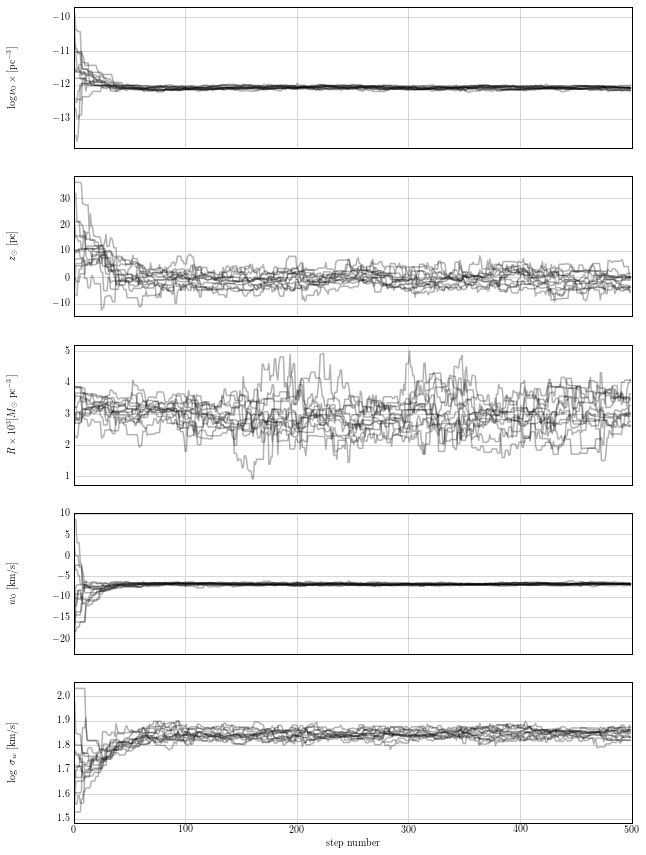

In [98]:
sampler = run_mcmc(
    nwalkers, ndim, p0, dim, log_posterior_no, consume_samples_no, 
    args=(data, locs, scales, dim, norm_list, uni_list, simple), 
    cores=16, plot=True, step=500, simple=simple
)

100%|██████████| 2000/2000 [02:10<00:00, 15.27it/s]


Multiprocessing took 131.1 seconds


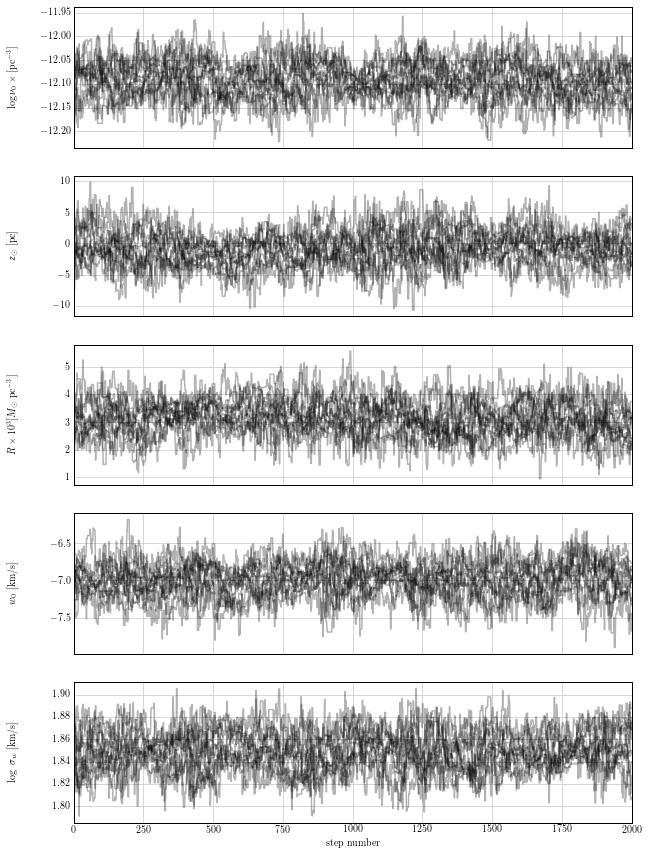

In [99]:
next_p0 = sampler.get_chain()[-1]
sampler_new = run_mcmc(
    nwalkers, ndim, next_p0, dim, log_posterior_no, consume_samples_no, 
    args=(data, locs, scales, dim, norm_list, uni_list, simple), 
    cores=16, plot=True, step=2000, simple=simple
)

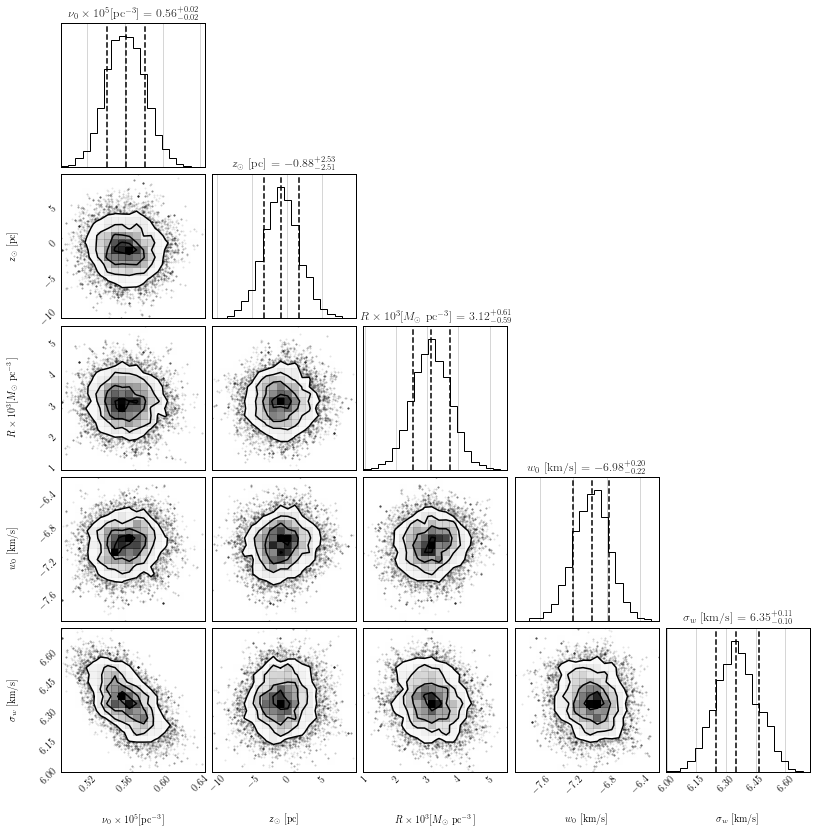

In [100]:
samples = sampler_new.get_chain()
plot_corner(samples, dim, consume_samples_no)

100%|██████████| 500/500 [00:13<00:00, 36.77it/s]


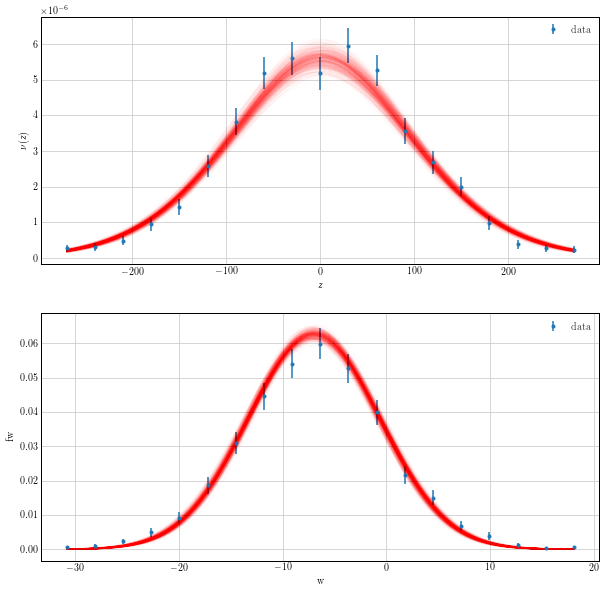

In [101]:
plot_fitting_no(sampler_new, data, dim, simple=simple, n=500)

In [157]:
df = get_dataframe_no(sampler_new, dim, locs, scales, norm_list, uni_list, nwalkers, simple=simple)
df

[                              ] 0% 

0/13: 100%|██████████| 2000/2000 [00:01<00:00, 1161.80it/s]

[##                            ] 8% <00:00:01|00:00:20> 


1/13: 100%|██████████| 2000/2000 [00:01<00:00, 1225.85it/s]

[####                          ] 15% <00:00:03|00:00:18> 


2/13: 100%|██████████| 2000/2000 [00:01<00:00, 1209.43it/s]

[######                        ] 23% <00:00:05|00:00:16> 


3/13: 100%|██████████| 2000/2000 [00:01<00:00, 1210.26it/s]

[#########                     ] 31% <00:00:06|00:00:15> 


4/13: 100%|██████████| 2000/2000 [00:01<00:00, 1187.40it/s]

[###########                   ] 38% <00:00:08|00:00:13> 


5/13: 100%|██████████| 2000/2000 [00:01<00:00, 1169.85it/s]

[#############                 ] 46% <00:00:10|00:00:11> 


6/13: 100%|██████████| 2000/2000 [00:01<00:00, 1109.13it/s]

[################              ] 54% <00:00:11|00:00:10> 


7/13: 100%|██████████| 2000/2000 [00:01<00:00, 1209.20it/s]

[##################            ] 62% <00:00:13|00:00:08> 


8/13: 100%|██████████| 2000/2000 [00:01<00:00, 1194.05it/s]

[####################          ] 69% <00:00:15|00:00:06> 


9/13: 100%|██████████| 2000/2000 [00:01<00:00, 1203.06it/s]

[#######################       ] 77% <00:00:16|00:00:05> 


10/13: 100%|██████████| 2000/2000 [00:01<00:00, 1176.81it/s]

[#########################     ] 85% <00:00:18|00:00:03> 


11/13: 100%|██████████| 2000/2000 [00:01<00:00, 1207.03it/s]

[###########################   ] 92% <00:00:20|00:00:01> 


12/13: 100%|██████████| 2000/2000 [00:01<00:00, 1193.87it/s]

[##############################] 100% <00:00:21|00:00:00> 

Time: 21.92 s


#,log_nu0,zsun,R,log_prior,log_posterior,log_likelihood,w0_0,log_sigma_w_0,a_0,walker
0,-12.161736954466088,-3.5291451650520407,0.003295161553903478,-2.122135296970842,351.203806710779,353.32594200774986,-6.913465206974633,1.860376620212588,0.9811952295164478,0
1,-12.161736954466088,-3.5291451650520407,0.003295161553903478,-2.122135296970842,351.203806710779,353.32594200774986,-6.913465206974633,1.860376620212588,0.9811952295164478,0
2,-12.21136295700878,-6.415899143482891,0.0034222540356912915,-2.1075577168661415,346.31905094233935,348.4266086592055,-6.998561533083182,1.8741498583106384,0.9059520211391822,0
3,-12.21136295700878,-6.415899143482891,0.0034222540356912915,-2.1075577168661415,346.31905094233935,348.4266086592055,-6.998561533083182,1.8741498583106384,0.9059520211391822,0
4,-12.164948989820113,-4.045473626114957,0.003263242146037182,-2.1328458675827617,350.756536066477,352.88938193405977,-7.1052440522314,1.860168395632337,0.905483433714128,0
...,...,...,...,...,...,...,...,...,...,...
"25,995",-12.07017774479955,2.1371550964142196,0.003113326343553989,-2.2210112490822196,353.2796609709533,355.5006722200355,-6.939925759774014,1.8454355460595988,0.9181670074901346,12
"25,996",-12.069037512107695,2.1133519535996124,0.003115602325356592,-2.2192060435856256,353.2754844825875,355.49469052617314,-6.94124868402524,1.8449142760081665,0.914455072866404,12
"25,997",-12.069037512107695,2.1133519535996124,0.003115602325356592,-2.2192060435856256,353.2754844825875,355.49469052617314,-6.94124868402524,1.8449142760081665,0.914455072866404,12
"25,998",-12.076638763314845,2.314142495301683,0.0032308306798665655,-2.146617462379835,353.2014299326939,355.3480473950737,-7.000876833971326,1.8504107078663956,0.9778641634684965,12


In [69]:
## save
df_dm = vaex.from_pandas(df)
df_dm.export(join(data_dir, f"dm_full_{name}"), progress=True)

export(hdf5) [########################################] 100.00% elapsed time  :     0.18s =  0.0m =  0.0h
 

gaia_(0.04)_(0.10).hdf5


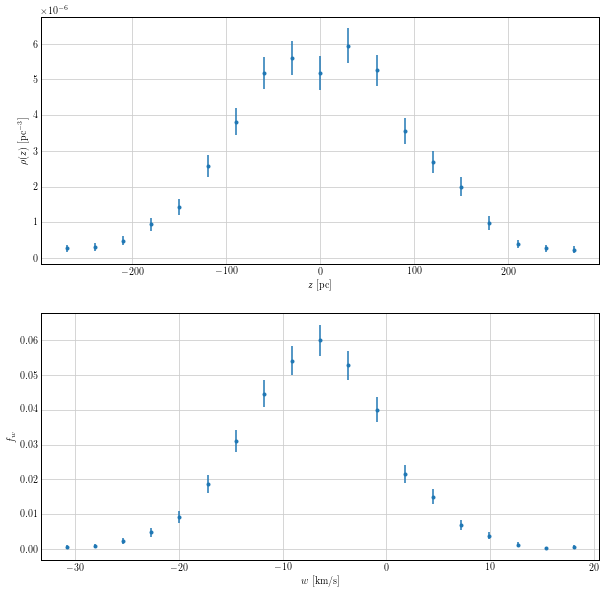

In [25]:
index = 1
simple = False
data, dim, w0, sigma_w, a_raw, name = load_data(index, number_files, velocity_files, velocity_popt_files)
print(name)
## plot data
plot_data(data)

In [26]:
## initialize prior
locs, scales, uni_list, norm_list = initialize_prior_no(dim, w0, sigma_w, a_raw, simple=simple)

In [27]:
# initialize walkers
p0, ndim, nwalkers = initialize_walkers_no(locs, scales, dim, simple=simple)

In [28]:
locs, uni_list, norm_list

({'log_nu0': -13.815510557964274,
  'zsun': -40,
  'R': 0.0034,
  'w0': array([-26.38133606]),
  'log_sigma_w': array([1.50663135]),
  'a': array([0.69918765]),
  'rhos': array([0.0104, 0.0277, 0.0073, 0.0005, 0.0006, 0.0018, 0.0018, 0.0029,
         0.0072, 0.0216, 0.0056, 0.0015]),
  'sigmaz': array([ 3.7,  7.1, 22.1, 39. , 15.5,  7.5, 12. , 18. , 18.5, 18.5, 20. ,
         20. ])},
 ['log_nu0', 'zsun', 'log_sigma_w', 'w0', 'a'],
 ['R', 'rhos', 'sigmaz'])

100%|██████████| 500/500 [01:11<00:00,  6.95it/s]


Multiprocessing took 72.2 seconds


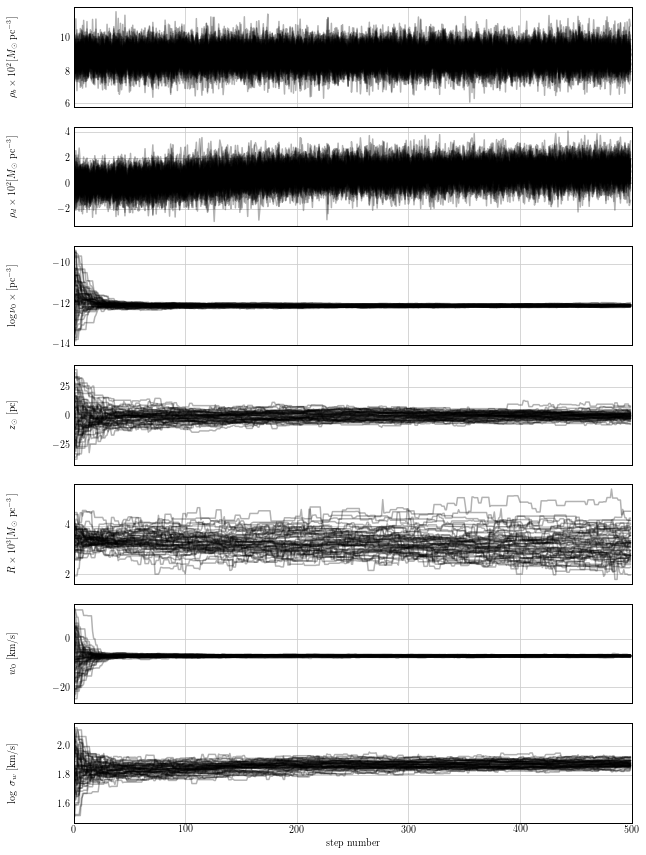

In [34]:
sampler = run_mcmc(
    nwalkers, ndim, p0, dim, log_posterior_no, consume_samples_no, 
    args=(data, locs, scales, dim, norm_list, uni_list, simple), 
    cores=16, plot=True, step=500, simple=simple
)

100%|██████████| 2000/2000 [04:51<00:00,  6.86it/s]


Multiprocessing took 292.5 seconds


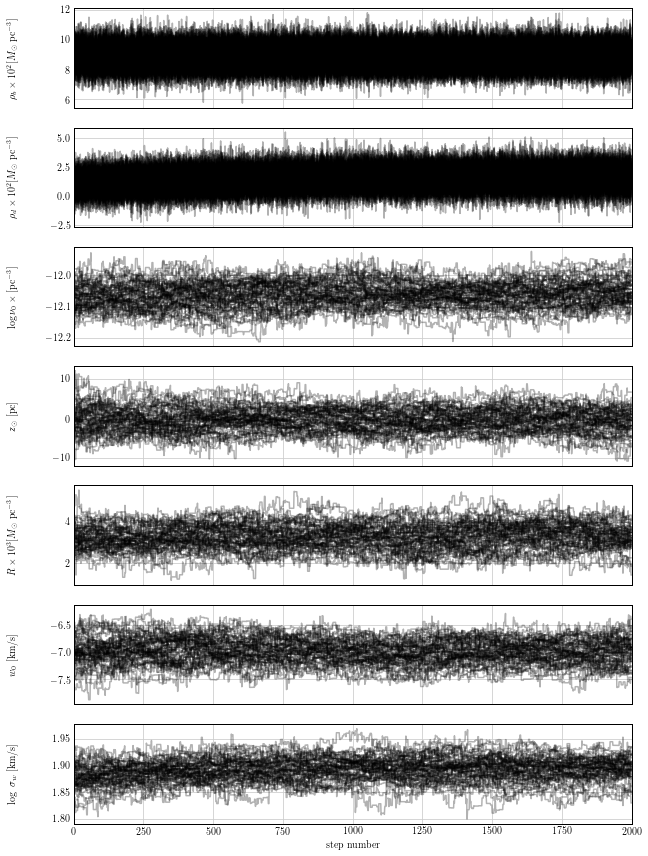

In [35]:
next_p0 = sampler.get_chain()[-1]
sampler_new = run_mcmc(
    nwalkers, ndim, next_p0, dim, log_posterior_no, consume_samples_no, 
    args=(data, locs, scales, dim, norm_list, uni_list, simple), 
    cores=16, plot=True, step=2000, simple=simple
)

100%|██████████| 2000/2000 [04:41<00:00,  7.11it/s]


Multiprocessing took 281.8 seconds


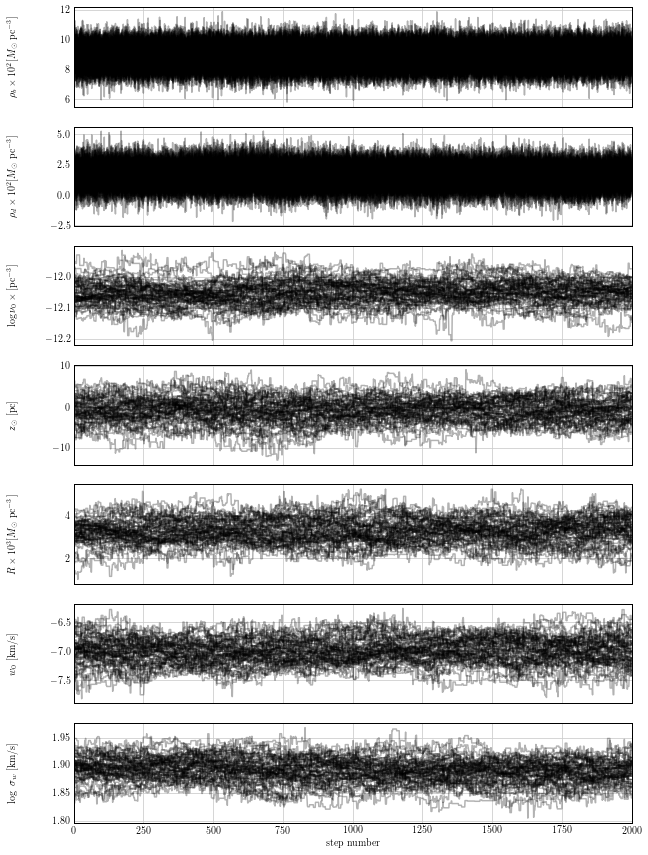

In [36]:
# again, if necessary
next_p0 = sampler_new.get_chain()[-1]
sampler_new = run_mcmc(
    nwalkers, ndim, next_p0, dim, log_posterior_no, consume_samples_no, 
    args=(data, locs, scales, dim, norm_list, uni_list, simple), 
    cores=16, plot=True, step=2000, simple=simple
)

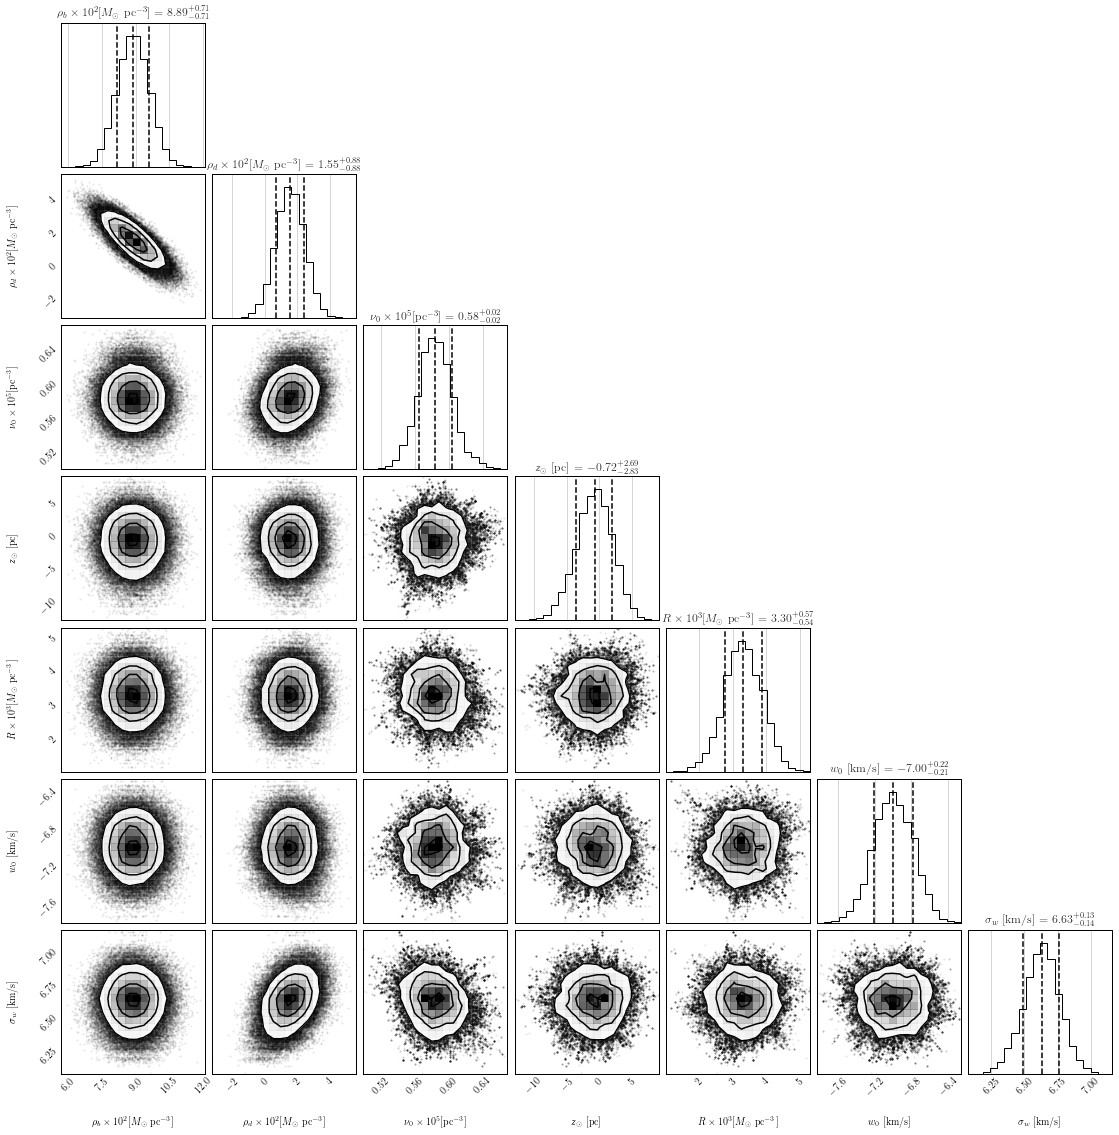

In [37]:
samples = sampler_new.get_chain()
plot_corner(samples, dim, consume_samples_no, simple=simple)

100%|██████████| 500/500 [00:11<00:00, 42.63it/s]


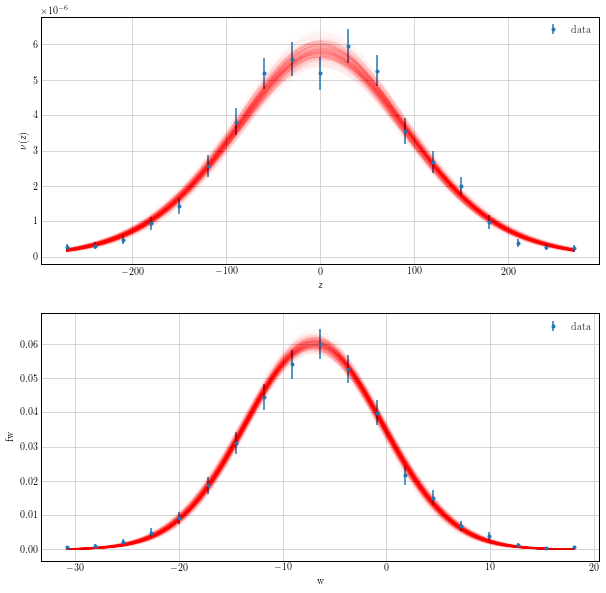

In [38]:
plot_fitting_no(sampler_new, data, dim, simple=simple, n=500)

In [39]:
df = get_dataframe_no(sampler_new, dim, locs, scales, norm_list, uni_list, nwalkers, simple=simple)
df

[                              ] 0% 

0/61: 100%|██████████| 2000/2000 [00:02<00:00, 906.56it/s]

[                              ] 2% <00:00:02|00:02:12> 


1/61: 100%|██████████| 2000/2000 [00:02<00:00, 928.70it/s]

[                              ] 3% <00:00:04|00:02:08> 


2/61: 100%|██████████| 2000/2000 [00:02<00:00, 929.52it/s]

[#                             ] 5% <00:00:06|00:02:06> 


3/61: 100%|██████████| 2000/2000 [00:02<00:00, 923.49it/s]

[#                             ] 7% <00:00:08|00:02:03> 


4/61: 100%|██████████| 2000/2000 [00:02<00:00, 922.92it/s]

[##                            ] 8% <00:00:10|00:02:01> 


5/61: 100%|██████████| 2000/2000 [00:02<00:00, 917.01it/s]

[##                            ] 10% <00:00:13|00:01:59> 


6/61: 100%|██████████| 2000/2000 [00:02<00:00, 914.79it/s]

[###                           ] 11% <00:00:15|00:01:57> 


7/61: 100%|██████████| 2000/2000 [00:02<00:00, 919.25it/s]

[###                           ] 13% <00:00:17|00:01:55> 


8/61: 100%|██████████| 2000/2000 [00:02<00:00, 919.92it/s]

[####                          ] 15% <00:00:19|00:01:53> 


9/61: 100%|██████████| 2000/2000 [00:02<00:00, 929.68it/s]

[####                          ] 16% <00:00:21|00:01:50> 


10/61: 100%|██████████| 2000/2000 [00:02<00:00, 909.81it/s]

[#####                         ] 18% <00:00:23|00:01:48> 


11/61: 100%|██████████| 2000/2000 [00:02<00:00, 927.78it/s]

[#####                         ] 20% <00:00:26|00:01:46> 


12/61: 100%|██████████| 2000/2000 [00:02<00:00, 925.92it/s]

[######                        ] 21% <00:00:28|00:01:44> 


13/61: 100%|██████████| 2000/2000 [00:02<00:00, 931.11it/s]

[######                        ] 23% <00:00:30|00:01:42> 


14/61: 100%|██████████| 2000/2000 [00:02<00:00, 923.36it/s]

[#######                       ] 25% <00:00:32|00:01:39> 


15/61: 100%|██████████| 2000/2000 [00:02<00:00, 924.88it/s]

[#######                       ] 26% <00:00:34|00:01:37> 


16/61: 100%|██████████| 2000/2000 [00:02<00:00, 918.63it/s]

[########                      ] 28% <00:00:36|00:01:35> 


17/61: 100%|██████████| 2000/2000 [00:02<00:00, 917.83it/s]

[########                      ] 30% <00:00:39|00:01:33> 


18/61: 100%|██████████| 2000/2000 [00:02<00:00, 893.98it/s]

[#########                     ] 31% <00:00:41|00:01:31> 


19/61: 100%|██████████| 2000/2000 [00:02<00:00, 917.61it/s]

[#########                     ] 33% <00:00:43|00:01:29> 


20/61: 100%|██████████| 2000/2000 [00:02<00:00, 897.47it/s]

[##########                    ] 34% <00:00:45|00:01:27> 


21/61: 100%|██████████| 2000/2000 [00:02<00:00, 888.82it/s]

[##########                    ] 36% <00:00:48|00:01:25> 


22/61: 100%|██████████| 2000/2000 [00:02<00:00, 896.43it/s]

[###########                   ] 38% <00:00:50|00:01:23> 


23/61: 100%|██████████| 2000/2000 [00:02<00:00, 893.72it/s]

[###########                   ] 39% <00:00:52|00:01:20> 


24/61: 100%|██████████| 2000/2000 [00:02<00:00, 907.54it/s]

[############                  ] 41% <00:00:54|00:01:18> 


25/61: 100%|██████████| 2000/2000 [00:02<00:00, 908.31it/s]

[############                  ] 43% <00:00:56|00:01:16> 


26/61: 100%|██████████| 2000/2000 [00:02<00:00, 884.97it/s]

[#############                 ] 44% <00:00:59|00:01:14> 


27/61: 100%|██████████| 2000/2000 [00:02<00:00, 886.88it/s]

[#############                 ] 46% <00:01:01|00:01:12> 


28/61: 100%|██████████| 2000/2000 [00:02<00:00, 902.76it/s]

[##############                ] 48% <00:01:03|00:01:10> 


29/61: 100%|██████████| 2000/2000 [00:02<00:00, 920.41it/s]

[##############                ] 49% <00:01:05|00:01:08> 


30/61: 100%|██████████| 2000/2000 [00:02<00:00, 904.58it/s]

[###############               ] 51% <00:01:08|00:01:05> 


31/61: 100%|██████████| 2000/2000 [00:02<00:00, 913.59it/s]

[###############               ] 52% <00:01:10|00:01:03> 


32/61: 100%|██████████| 2000/2000 [00:02<00:00, 894.83it/s]

[################              ] 54% <00:01:12|00:01:01> 


33/61: 100%|██████████| 2000/2000 [00:02<00:00, 922.56it/s]

[################              ] 56% <00:01:14|00:00:59> 


34/61: 100%|██████████| 2000/2000 [00:02<00:00, 920.26it/s]

[#################             ] 57% <00:01:16|00:00:57> 


35/61: 100%|██████████| 2000/2000 [00:02<00:00, 914.14it/s]

[#################             ] 59% <00:01:18|00:00:54> 


36/61: 100%|██████████| 2000/2000 [00:02<00:00, 898.82it/s]

[##################            ] 61% <00:01:21|00:00:52> 


37/61: 100%|██████████| 2000/2000 [00:02<00:00, 890.39it/s]

[##################            ] 62% <00:01:23|00:00:50> 


38/61: 100%|██████████| 2000/2000 [00:02<00:00, 921.18it/s]

[###################           ] 64% <00:01:25|00:00:48> 


39/61: 100%|██████████| 2000/2000 [00:02<00:00, 917.10it/s]

[###################           ] 66% <00:01:27|00:00:46> 


40/61: 100%|██████████| 2000/2000 [00:02<00:00, 918.53it/s]

[####################          ] 67% <00:01:30|00:00:43> 


41/61: 100%|██████████| 2000/2000 [00:02<00:00, 909.16it/s]

[####################          ] 69% <00:01:32|00:00:41> 


42/61: 100%|██████████| 2000/2000 [00:02<00:00, 926.25it/s]

[#####################         ] 70% <00:01:34|00:00:39> 


43/61: 100%|██████████| 2000/2000 [00:02<00:00, 913.20it/s]

[#####################         ] 72% <00:01:36|00:00:37> 


44/61: 100%|██████████| 2000/2000 [00:02<00:00, 934.50it/s]

[######################        ] 74% <00:01:38|00:00:35> 


45/61: 100%|██████████| 2000/2000 [00:02<00:00, 899.41it/s]

[######################        ] 75% <00:01:40|00:00:32> 


46/61: 100%|██████████| 2000/2000 [00:02<00:00, 920.25it/s]

[#######################       ] 77% <00:01:43|00:00:30> 


47/61: 100%|██████████| 2000/2000 [00:02<00:00, 914.63it/s]

[#######################       ] 79% <00:01:45|00:00:28> 


48/61: 100%|██████████| 2000/2000 [00:02<00:00, 910.48it/s]

[########################      ] 80% <00:01:47|00:00:26> 


49/61: 100%|██████████| 2000/2000 [00:02<00:00, 899.87it/s]

[########################      ] 82% <00:01:49|00:00:24> 


50/61: 100%|██████████| 2000/2000 [00:02<00:00, 906.14it/s]

[#########################     ] 84% <00:01:51|00:00:21> 


51/61: 100%|██████████| 2000/2000 [00:02<00:00, 903.41it/s]

[#########################     ] 85% <00:01:54|00:00:19> 


52/61: 100%|██████████| 2000/2000 [00:02<00:00, 914.96it/s]

[##########################    ] 87% <00:01:56|00:00:17> 


53/61: 100%|██████████| 2000/2000 [00:02<00:00, 890.02it/s]

[##########################    ] 89% <00:01:58|00:00:15> 


54/61: 100%|██████████| 2000/2000 [00:02<00:00, 830.18it/s]

[###########################   ] 90% <00:02:01|00:00:13> 


55/61: 100%|██████████| 2000/2000 [00:02<00:00, 900.76it/s]

[###########################   ] 92% <00:02:03|00:00:11> 


56/61: 100%|██████████| 2000/2000 [00:02<00:00, 889.21it/s]

[############################  ] 93% <00:02:05|00:00:08> 


57/61: 100%|██████████| 2000/2000 [00:02<00:00, 910.90it/s]

[############################  ] 95% <00:02:07|00:00:06> 


58/61: 100%|██████████| 2000/2000 [00:02<00:00, 901.79it/s]

[############################# ] 97% <00:02:09|00:00:04> 


59/61: 100%|██████████| 2000/2000 [00:02<00:00, 893.95it/s]

[############################# ] 98% <00:02:12|00:00:02> 


60/61: 100%|██████████| 2000/2000 [00:02<00:00, 903.50it/s]

[##############################] 100% <00:02:14|00:00:00> 

Time: 134.36 s


#,log_nu0,zsun,R,log_prior,log_posterior,log_likelihood,w0_0,log_sigma_w_0,a_0,rhob_0,sigmaz_0,rhob_1,sigmaz_1,rhob_2,sigmaz_2,rhob_3,sigmaz_3,rhob_4,sigmaz_4,rhob_5,sigmaz_5,rhob_6,sigmaz_6,rhob_7,sigmaz_7,rhob_8,sigmaz_8,rhob_9,sigmaz_9,rhob_10,sigmaz_10,rhob_11,sigmaz_11,walker
0,-11.973796313447465,5.332868715170134,0.003036912594979335,40.02199177966377,400.8694235776331,360.8474317979693,-6.956493742541763,1.9221235898177218,0.8732933865176564,0.018544880418763045,3.643393889076093,0.03851208620536489,7.831580843092877,0.007879744935240521,18.541565835690314,0.00046475407538541384,44.458191276966446,0.0006657322045433148,17.296180777635108,0.0014835387989042478,7.663979901458789,0.001543381891344247,13.915733262256085,0.002939303846111155,17.206284454354,0.006351710763521848,19.4677126963611,0.02910982693090771,20.692911048469455,0.005837346302832972,25.758818731133214,0.0013879238678581097,16.94279824338699,0
1,-11.973796313447465,5.332868715170134,0.003036912594979335,40.02199177966377,400.8694235776331,360.8474317979693,-6.956493742541763,1.9221235898177218,0.8732933865176564,0.018544880418763045,3.643393889076093,0.03851208620536489,7.831580843092877,0.007879744935240521,18.541565835690314,0.00046475407538541384,44.458191276966446,0.0006657322045433148,17.296180777635108,0.0014835387989042478,7.663979901458789,0.001543381891344247,13.915733262256085,0.002939303846111155,17.206284454354,0.006351710763521848,19.4677126963611,0.02910982693090771,20.692911048469455,0.005837346302832972,25.758818731133214,0.0013879238678581097,16.94279824338699,0
2,-11.973796313447465,5.332868715170134,0.003036912594979335,40.02199177966377,400.8694235776331,360.8474317979693,-6.956493742541763,1.9221235898177218,0.8732933865176564,0.018544880418763045,3.643393889076093,0.03851208620536489,7.831580843092877,0.007879744935240521,18.541565835690314,0.00046475407538541384,44.458191276966446,0.0006657322045433148,17.296180777635108,0.0014835387989042478,7.663979901458789,0.001543381891344247,13.915733262256085,0.002939303846111155,17.206284454354,0.006351710763521848,19.4677126963611,0.02910982693090771,20.692911048469455,0.005837346302832972,25.758818731133214,0.0013879238678581097,16.94279824338699,0
3,-11.973796313447465,5.332868715170134,0.003036912594979335,40.02199177966377,400.8694235776331,360.8474317979693,-6.956493742541763,1.9221235898177218,0.8732933865176564,0.018544880418763045,3.643393889076093,0.03851208620536489,7.831580843092877,0.007879744935240521,18.541565835690314,0.00046475407538541384,44.458191276966446,0.0006657322045433148,17.296180777635108,0.0014835387989042478,7.663979901458789,0.001543381891344247,13.915733262256085,0.002939303846111155,17.206284454354,0.006351710763521848,19.4677126963611,0.02910982693090771,20.692911048469455,0.005837346302832972,25.758818731133214,0.0013879238678581097,16.94279824338699,0
4,-11.973796313447465,5.332868715170134,0.003036912594979335,40.02199177966377,400.8694235776331,360.8474317979693,-6.956493742541763,1.9221235898177218,0.8732933865176564,0.018544880418763045,3.643393889076093,0.03851208620536489,7.831580843092877,0.007879744935240521,18.541565835690314,0.00046475407538541384,44.458191276966446,0.0006657322045433148,17.296180777635108,0.0014835387989042478,7.663979901458789,0.001543381891344247,13.915733262256085,0.002939303846111155,17.206284454354,0.006351710763521848,19.4677126963611,0.02910982693090771,20.692911048469455,0.005837346302832972,25.758818731133214,0.0013879238678581097,16.94279824338699,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"121,995",-12.055869998402992,-1.8014093375537932,0.0034469702531531145,46.74884800233044,407.85808495205555,361.10923694972513,-6.961917795263335,1.8626930267008337,0.8312079894205286,0.010678605235426875,3.533009063572741,0.0352738338214569,6.342187971597529,0.0070805869267802305,25.65999208860471,0.000499859825729075,34.4000230829932

In [40]:
df.shape

(122000, 34)

In [ ]:
## save
df.export(join(data_dir, f"no_full_{name}"), progress=True)